In [12]:
import os
import pickle
import scipy 
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.signal import get_window
import python_speech_features as mfcc
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import MiniBatchDictionaryLearning

Missing colon in file 'C:\\Users\\somakiko\\.matplotlib\\matplotlibrc', line 2 ('\x00')
Missing colon in file 'C:\\Users\\somakiko\\.matplotlib\\matplotlibrc', line 4 ('\x00')
Missing colon in file 'C:\\Users\\somakiko\\.matplotlib\\matplotlibrc', line 5 ('\x00')

Bad key ے‏b a c k e n d  in file C:\Users\somakiko\.matplotlib\matplotlibrc, line 1 ('ے\u200fb\x00a\x00c\x00k\x00e\x00n\x00d\x00:\x00 \x00T\x00k\x00A\x00g\x00g\x00')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key  b a c k e n d  in file C:\Users\somakiko\.matplotlib\matplotlibrc, line 3 ('\x00b\x00a\x00c\x00k\x00e\x00n\x00d\x00:\x00 \x00T\x00k\x00A\x00g\x00g\x00')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution


## Feartures Extraction

In [62]:
# def extract_features(file_path):

#     x, sr = librosa.load(file_path)

#     freqs = np.fft.fftfreq(x.size)

#     def describe_freq(freqs):
#         mean = np.mean(freqs)
#         std = np.std(freqs) 
#         maxv = np.amax(freqs) 
#         minv = np.amin(freqs) 
#         median = np.median(freqs)
#         skew = scipy.stats.skew(freqs)
#         kurt = scipy.stats.kurtosis(freqs)
#         q1 = np.quantile(freqs, 0.25)
#         q3 = np.quantile(freqs, 0.75)
#         mode = scipy.stats.mode(freqs)[0][0]
#         iqr = scipy.stats.iqr(freqs)

#         return [mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr]

#     def rmse(x):
#         return [np.sum(x**2)]

#     def rmse2(x):
#         return [np.sqrt(np.mean(x**2))]

#     zero_crossings = [sum(librosa.zero_crossings(x, pad=False))]

#     tempo = [librosa.beat.tempo(x)[0]]

#     # mfcc=librosa.feature.mfcc(x)
#     mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=1)



#     hop_length = 512
#     oenv      = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
#     # tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
#     spec_centroid = librosa.feature.spectral_centroid(x)[0]
#     spectral_bandwidth=librosa.feature.spectral_bandwidth(x)[0]
#     spectral_contrast=librosa.feature.spectral_contrast(x)[0]
#     spectral_flatness=librosa.feature.spectral_flatness(x)[0]
#     spectral_rolloff=librosa.feature.spectral_rolloff(x)[0]

#     combined = np.hstack([describe_freq(freqs),rmse(x),rmse2(x),zero_crossings,tempo,mfcc[0],oenv,spec_centroid,spectral_bandwidth,
#                         spectral_contrast, spectral_flatness, spectral_rolloff]) 
#     return combined

# extract_features('./files/magdy/100.wav')

##### MFCC Feature

In [13]:
def calculate_delta(array):

    rows,cols = array.shape
    print(rows)
    print(cols)
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first =0
            else:
                first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(file_path):
    audio , sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfcc_feature = mfcc.mfcc(audio,sample_rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    print(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

In [32]:
names = ['Michael','ahmed_ashraf','Belal']
features = {}
# directory = './Speaker_Train_Data/'
# for audio in os.listdir(directory):
#     audio_path = directory + audio
#     if 'Michael'

# featuresMichael = []
# featuresAhmed = []
# featuresBelal = []
# featuresOthers = []
print(os.getcwd())
directory = './Speaker_Train_Data/'
for audio in os.listdir(directory):
    audio_path = directory + audio
    noNames = True
    for name in names:
        if name in audio:
            noNames = False
            if name in features:
                features[name] = []
            features[name] = np.vstack(extract_features(audio_path) )
    if noNames:
        if 'others' not in features:
            features['others'] = []
        features['others'] = np.vstack(extract_features(audio_path) )
    
    # if 'Michael' in audio:
    #     if 'Michael' not in features:
    #         features['michael'] = []
    #     features['Michael']=np.vstack(extract_features(audio_path) )
    # elif "ahmed_ashraf" in audio:
    #     featuresAhmed = np.vstack(extract_features(audio_path) )
    # elif "Belal" in audio:
    #     featuresBelal = np.vstack(extract_features(audio_path))
    # else:
    #     featuresOthers = np.vstack(extract_features(audio_path))
        


d:\SBME\3rd year\DSP\repo final\audio-recognition-2\Ahmed_Belal_Micheal
[[-1.79665626 -2.83845625  0.04886008 ...  0.09222027  0.49165605
   0.40566417]
 [-1.78038652 -2.97462587  0.05818911 ...  0.06660917 -0.03340305
   0.09423245]
 [-1.78518027 -2.6211314   0.57985054 ...  0.22658176 -0.01658361
  -0.19492909]
 ...
 [-0.36609324  0.45612891 -0.25354427 ...  0.70893374 -1.88660753
  -0.75542166]
 [-0.3571539   0.17816698 -0.46198842 ...  0.93698173 -1.8021269
  -0.59890767]
 [-0.41501347  0.03239991 -0.57600283 ...  1.68042355 -1.70095064
  -0.20002541]]
198
20
[[-1.84304415 -2.85069453  0.18160187 ... -0.10943049  0.4052857
   0.31067984]
 [-1.82531572 -2.98385921  0.19108791 ... -0.13492548 -0.05823079
  -0.01690311]
 [-1.83073235 -2.64611091  0.71148135 ...  0.04566863 -0.0492019
  -0.3122294 ]
 ...
 [-0.3216166   0.20393947 -0.38128435 ...  1.68888666 -0.5042468
  -0.87791314]
 [-0.35024563  0.30629646 -0.16823819 ...  0.96338575 -0.04199064
  -0.75433947]
 [-0.3272535   0.350777

In [34]:
models = {}
for name,val in features.items():
    models[name] = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
    models[name].fit(val)

# michael_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
# michael_gmm.fit(featuresMichael)

# belal_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
# belal_gmm.fit(featuresBelal)

# ahmed_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
# ahmed_gmm.fit(featuresAhmed)

# others_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
# others_gmm.fit(featuresOthers)

# open_gmm = GaussianMixture(n_components = 6, max_iter = 2000, covariance_type='diag',n_init = 3)
# open_gmm.fit(openFeatures)

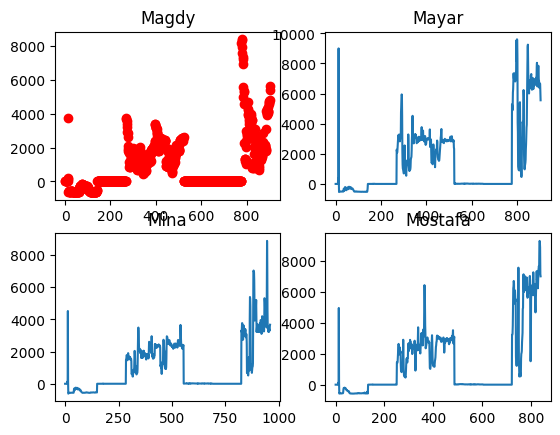

In [47]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

# For Sine Function
axis[0, 0].plot(features['Michael'],'ro')
axis[0, 0].set_title("michael")

# For Cosine Function
axis[0, 1].plot(features['Belal'])
axis[0, 1].set_title("Belal")

# For Tangent Function
axis[1, 0].plot(features['ahmed_ashraf'])
axis[1, 0].set_title("ahmed_ashraf")

# For Tanh Function
axis[1, 1].plot(features['others'])
axis[1, 1].set_title("others")

names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

# Combine all the operations and display
plt.show()

In [35]:
for key,val in models.items():
    pickle.dump(val,open(key,'wb'))
# pickle.dump(michael_gmm,open('mayar.gmm','wb'))
# pickle.dump(belal_gmm,open('mina.gmm','wb'))
# pickle.dump(ahmed_gmm,open('magdy.gmm','wb'))
# pickle.dump(others_gmm,open('mostafa.gmm','wb'))
# pickle.dump(open_gmm,open('open.gmm','wb'))

In [36]:
test = extract_features('./testing_set/sample.wav')
print(test.size)

[[-1.94294214 -2.69282352  0.44131095 ...  0.95872406  0.03651721
  -0.01693065]
 [-1.9266584  -2.65292246  0.4404733  ...  0.16673945  0.52054282
   0.26351626]
 [-1.94191965 -2.83548518  0.12599302 ... -0.55556129  0.42203053
   0.56501133]
 ...
 [-0.95447206 -0.5520988   1.94059983 ... -0.2653658   0.26812312
  -0.4881633 ]
 [-0.96504184 -0.52964909  1.84670922 ... -0.20723925  0.17428655
  -0.99110732]
 [-0.95104124 -0.49132925  2.19161926 ... -0.3345238   0.23701734
  -1.36536509]]
198
20
7920


In [37]:
for modelName,model in models.items():
    print(f'{modelName} scored {model.score(test)}')
# scores_1=np.array(open_gmm.score(test))
# scores_2=np.array(michael_gmm.score(test))
# scores_3=np.array(belal_gmm.score(test))
# scores_4=np.array(ahmed_gmm.score(test))
# scores_5=np.array(others_gmm.score(test))

# print(scores_1)
# print(scores_2)
# print(scores_3)
# print(scores_4)
# print(scores_5)


others scored -35.91219795090282
ahmed_ashraf scored -30.409275133862014
Belal scored -35.678628170653866
Michael scored -29.873226218703554
